#Tipping Curve analysis

Revision History:
* (Sean) Copy of Sean's RTS analysis script
* (Ruby) Added fall-over to use KAT-7 sensor data when environmental data is not available
* (Ruby) Small changes for ease of use

# User Inputs

In [1]:
#filename = '/var/kat/archive/data/MeerKATAR1/telescope_products/2015/11/27/1448637030.h5'
filename = '/var/kat/archive/data/MeerKATAR1/telescope_products/2015/12/03/1449138235.h5'

antenna_name='m024'

#Processing script

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
import pickle
import katdal
import scape
import scikits.fitting as fit
import gsm
import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord

%matplotlib inline

# Sky temperature

For KAT-7 the sky temperature map used is adopted from a map produced for use in calibrating L-band ocean salinity observations. http://oceancolor.gsfc.nasa.gov/AQUARIUS/DinnatEtAl2010/. Note that this map included HI measurements, scaled by the fraction of band that it occupies in the observation satellite window.  This may result in an overestimation of the sky brightness temperature in the Galactic plane.  It is preferable to have one that just ignores the HI contritibution since the map is scaled by a power law for each frequency.  Need to have a closer look at this.  Also, I suspect the map currently used has been convolved with KAT-7 beam.  We may want a different beam for MeerKAT.



The global sky model has been used. It is in the gsm module that has been imported. The global sky model is hosted at http://space.mit.edu/~angelica/gsm/index.html The GSM will produce an all sky map at any frequency between 10 MHz and 100 GHz using a principle component based model fitted to a number of publicly available maps. The file format is a single column text file. The map structure follows the Healpix (http://healpix.sourceforge.net/) ring scheme. The map is in galatic co-ordinates.
The reference paper can be found here: http://adsabs.harvard.edu/abs/2008MNRAS.388..247D
The models are generated by a fortran programme - changes may need to be made to get it to compile.
The maps are numpy arrays and can be manipulated using healpy (http://healpy.readthedocs.org/en/latest/)

In [3]:
class Sky_temp:
    import gsm
    import healpy as hp
    from astropy import units as u
    from astropy.coordinates import SkyCoord
    """
       T_sky = T_cont + T_cmb  from the global sky model
       Read in  file, and provide a method of passing back the Tsky temp a at a position
    """
    def __init__(self,nu=1828.0,path="/var/kat/archive/data/models/gsm",diameter=13.5,smooth=True):
        """ Load The Tsky data from an inputfile in FITS format and scale to frequency
        This takes in 1 parameter:
        nu (MHz) center frequency
        
        """
        if smooth :
            self.freq_map = hp.sphtfunc.smoothing(gsm.get_freq(nu,path),fwhm=(1.17*(3e8/(nu*1e6))/diameter ) )
        else :
            self.freq_map = gsm.get_freq(nu,path)
        self.freq_map += 2.725  # CMB temperature not included in de Oliveira-Costa's GSM  
        self.nu = nu
        self.smooth=smooth

    def Tsky(self,ra,dec):
        """given RA/Dec in Degrees  return the value of the spot
        assuming the healpix map is in Galatic coords
        """
        c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
        l = c.galactic.l.radian
        b = c.galactic.b.radian
        nside = hp.npix2nside(self.freq_map.shape[0])
        ipix = hp.ang2pix(nside, np.pi/2.0 - b , l % (np.pi*2),nest=False)
        return self.freq_map[ipix]

    
    def plot_sky(self,ra=None,dec=None,norm = 'log',unit='Kelvin',heapix_array=None):
        """ plot_sky plots the sky tempreture and overlays pointing centers as red dots
        The sky tempreture is the data that was loaded when the class was iniitated.
        plot_sky takes in 3 optional parameters:
                ra,dec  are list/1D-array like values of right assension and declanation
        returns matplotlib figure object that the plot is assosated with.
        """
        #self.freq_map
        fig = plt.figure(figsize=(16,9))
        hp.cartview(self.freq_map,norm = norm,unit=unit,fig=fig.number)
        c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
        l = np.degrees(-c.galactic.l.radian % (np.pi*2))
        b = np.degrees(c.galactic.b.radian)
        plt.plot(l,b,'ro')
        #hp.graticule()
        return fig

##Spillover models

Can be found here:

https://katfs.kat.ac.za/svnSystemEngineering/MeerKAT/4%20System%20Level5/5%20Integration%20&%20Verification/Analysis/Receptor/Predictions/SpilloverAndEfficiency/

MK_L_Tspill_AsBuilt_atm_mask.dat includes ground & atmospheric radiation pickup, the cosmic microwave background and an average Galactic noise of 20 K at 408 MHz, but the main beam and first sidelobe is zeroed out in the pattern integral. The ground is assumed to be in thermal equilibrium at 300 K with reflection approximated as the average of that of H & V. The atmosphere is modelled with the sky brightness model of Cortés-Medellín in SKA Memo 95, employing nominal values for atmospheric temperature, pressure and water vapour density which is believed to be representative of the Karoo environment except for winter time.


In [4]:
class Spill_Temp:
    """Load spillover models and interpolate to centre observing frequency."""
    def __init__(self,filename=None):
        """ The class Spill_temp reads the spillover model from file and
        produces fitted functions for a frequency
        The class/__init__function takes in one parameter:
        filename : (default=none) This is the filename containing
               the spillover model ,this file has 3 cols:
               theta(Degrees, 0 at Zenith),tempreture (MHz),Frequency (MHz)
               if there are no files zero spilover is assumed.
               function save makes a file of the correct format
        returns :
               dict  spill with two elements 'HH' 'VV' that
               are intepolation functions that take in elevation & Frequency(MHz)
               and return tempreture in Kelven.
        """
        try:
            datafile =np.loadtxt(filename)
            elevation = datafile[1:,0]
            numfreqs = (datafile.shape[1]-1)//2
            freqs= datafile[0,1::2]
            elevation_list = np.array(())
            freq_list = np.array(())
            data_list = np.array(())
            elevation_list = np.r_[elevation_list,elevation]
            freq_list = np.r_[freq_list,np.ones_like(elevation)*800.0] ## Hard code the lower limit to avoid nans
            data_list = np.r_[data_list,datafile[1:,1+0*2]]
            for x in range(numfreqs):
                elevation_list = np.r_[elevation_list,elevation]
                freq_list = np.r_[freq_list,np.ones_like(elevation)*freqs[x]]
                data_list = np.r_[data_list,datafile[1:,1+x*2]]

            T_H = fit.Delaunay2DScatterFit() 
            T_H.fit((90.-elevation_list,freq_list),data_list)

            elevation_list = np.array(())
            freq_list = np.array(())
            data_list = np.array(())
            elevation_list = np.r_[elevation_list,elevation]
            freq_list = np.r_[freq_list,np.ones_like(elevation)*800.0]  ## Hard code the lower limit to avoid nans
            data_list = np.r_[data_list,datafile[1:,1+0*2+1]]
            for x in range(numfreqs):
                elevation_list = np.r_[elevation_list,elevation]
                freq_list = np.r_[freq_list,np.ones_like(elevation)*freqs[x]]
                data_list = np.r_[data_list,datafile[1:,1+x*2+1]]
            T_V = fit.Delaunay2DScatterFit()
            T_V.fit((90.-elevation_list,freq_list),data_list)
            self.spill = {}
            self.spill['HH'] = T_H # The HH and VV is a scape thing
            self.spill['VV'] = T_V
            #print self.spill['HH']((90.-elevation_list,freq_list))
   
        except IOError:
            spillover_H = np.array([[0.,90.,0.,90.],[0.,0.,0.,0.],[900.,900.,2000.,2000.]])
            spillover_V = np.array([[0.,90.,0.,90.],[0.,0.,0.,0.],[900.,900.,2000.,2000.]])
            spillover_H[0]= 90-spillover_H[0]
            spillover_V[0]= 90-spillover_V[0]
            T_H = fit.Delaunay2DScatterFit() 
            T_V = fit.Delaunay2DScatterFit()
            T_H.fit(spillover_H[[0,2],:],spillover_H[1,:])
            T_V.fit(spillover_V[[0,2],:],spillover_V[1,:])
            self.spill = {}
            self.spill['HH'] = T_H # The HH and VV is a scape thing
            self.spill['VV'] = T_V
            warnings.warn('Warning: Failed to load Spillover models, setting models to zeros')
            print "error"
        # the models are in a format of theta=0  == el=90


#Aperture Efficiency Models:
Load aperture efficiency models and interpolate to centre observing frequency.



In [5]:
class aperture_efficiency_models:
    """Load aperture_efficiency_models and interpolate to centre observing frequency."""
    def __init__(self,filenameH='',filenameV='',):
        """ The class aperture_efficiency reads the aperture_efficiency
        model from file and
        produces fitted functions for a frequency
        The class/__init__function takes in one parameter:
        filename : (default='') This is the filename
               of the recever model
               these files have 2 cols:
                Frequency (MHz),aperture_efficiency  (fraction),
               if there are no file 15k recever  is assumed.
        returns :
               dict  spill with two elements 'HH' 'VV' that
               are intepolation functions that take in Frequency(MHz)
               and return fraction.
        """
        try:
            aperture_eff_h = np.loadtxt(filenameH,comments='#')# Change units to fraction
            a800 = np.zeros((aperture_eff_h.shape[0]+2,2))
            a800[0,:] = [800,aperture_eff_h[0,1]]
            a800[1:-1,:] = aperture_eff_h
            a800[-1,:] = [2000,aperture_eff_h[-1,1]]
            aperture_eff_h = a800

            aperture_eff_v = np.loadtxt(filenameV,comments='#')# Change units to fraction
            a800 = np.zeros((aperture_eff_v.shape[0]+2,2))
            a800[0,:] = [800,aperture_eff_v[0,1]]
            a800[1:-1,:] = aperture_eff_v
            a800[-1,:] = [2000,aperture_eff_v[-1,1]]
            aperture_eff_v = a800
            
        except IOError:
            receiver_h = np.array([[800.,2000],[75.,75.]])
            warnings.warn('Warning: Failed to load aperture_efficiency models, setting models to 0.75 ')
        #Assume  Provided models are a function of zenith angle & frequency
        T_H = fit.PiecewisePolynomial1DFit()
        T_V = fit.PiecewisePolynomial1DFit()
        T_H.fit(aperture_eff_h[:,0],aperture_eff_h[:,1]/100.)
        T_V.fit(aperture_eff_v[:,0],aperture_eff_v[:,1]/100.)
        self.eff = {}
        self.eff['HH'] = T_H # The HH and VV is a scape thing
        self.eff['VV'] = T_V


#Receiver models

Will need to get hold of these.

How do we assess the validity of the models provided by EMSS?
These are determined by lab measurements for receiver noise for each receiver as they get delivered. 

Files are in the form, Freq, Gain, Noise Temperature


In [6]:
class Rec_Temp:
    """Load Receiver models and interpolate to centre observing frequency."""
    def __init__(self,filenameH='',filenameV=''):
        """ The class Rec_temp reads the receiver model from file and
        produces fitted functions for a frequency
        The class/__init__function takes in one parameter:
        filenameH : (default='') This is the filename
               of the recever model
               these files have 2 cols:
                Frequency (MHz),tempreture (MHz),
               if there are no file 15k recever  is assumed.
        returns :
               dict  spill with two elements 'HH' 'VV' that
               are intepolation functions that take in Frequency(MHz)
               and return tempreture in Kelven.
        """
        try:
            receiver_h = (np.loadtxt(filenameH,comments='%',delimiter=',')[:,[0,2] ]/(1e6,1.)).T # Change units to MHz # discard the gain col
            a800 = np.zeros((2,np.shape(receiver_h)[-1]+1))
            a800[:,0] = [800,receiver_h[1,0]]
            a800[:,1:] = receiver_h
            receiver_h = a800
            receiver_v = (np.loadtxt(filenameV,comments='%',delimiter=',')[:,[0,2] ]/(1e6,1.)).T # Change units to MHz  # discard the gain col
            a800 = np.zeros((2,np.shape(receiver_v)[-1]+1))
            a800[:,0] = [800,receiver_v[1,0]]
            a800[:,1:] = receiver_v
            receiver_v = a800
        except IOError:
            receiver_h = np.array([[800.,2000],[15.,15.]])
            receiver_v = np.array([[800.,2000],[15.,15.]])
            warnings.warn('Warning: Failed to load Receiver models, setting models to 15 K ')
        #Assume  Provided models are a function of zenith angle & frequency
        T_H = fit.PiecewisePolynomial1DFit()
        T_V = fit.PiecewisePolynomial1DFit()
        T_H.fit(receiver_h[0],receiver_h[1])
        T_V.fit(receiver_v[0],receiver_v[1])
        self.rec = {}
        self.rec['HH'] = T_H # The HH and VV is a scape thing
        self.rec['VV'] = T_V



#System Temperature

$T_{sys}(el) = T_{cmb}(ra,dec) + T_{gal}(ra,dec) + T_{atm}*(1-\exp(\frac{-\tau_{0}}{\sin(el)})) + T_{spill}(el) + T_{ant} + T_{rec}$

where

$T_{ant} = T_{spillthrough} + T_{diffraction}$


is unknown and determined from this test.



In [7]:
class System_Temp:
    """Extract tipping curve data points and surface temperature."""
    def __init__(self,d,freqs=1822,freq_index=0,elevation=None,ra=None,dec=None ,surface_temperature=23.0,air_relative_humidity=0.23):#d, nu, pol
        """ First extract total power in each scan (both mean and standard deviation) """
        T_skytemp = Sky_temp(nu=freqs)
        T_sky =  T_skytemp.Tsky
        self.units = d.data_unit
        
        self.name = d.antenna.name
        self.filename = d.filename
        self.elevation =  {}
        self.Tsys = {}
        self.sigma_Tsys = {}
        self.Tsys_sky = {}
        self.T_sky = []
        self.height = d.antenna.position_wgs84[2]
        self.pressure =  np.mean([line[1] for line in d.enviro['pressure'] ])
        self.air_relative_humidity = air_relative_humidity
        # Sort data in the order of ascending elevation
        valid_el = (elevation >= 10)
        self.elevation =  elevation[valid_el]
        self.ra = ra[valid_el]
        self.dec = dec[valid_el]
        self.surface_temperature = surface_temperature# Extract surface temperature from weather data
        self.freq = d.freqs[0]  #MHz Centre frequency of observation
        for pol in ['HH','VV']:
            power_stats = [scape.stats.mu_sigma(s.pol(pol)[:,freq_index]) for s in d.scans]
            tipping_mu, tipping_sigma = np.array([s[0] for s in power_stats]), np.array([s[1] for s in power_stats])
            tipping_mu, tipping_sigma = tipping_mu[sort_ind], tipping_sigma[sort_ind]
            self.Tsys[pol] = tipping_mu[valid_el]
            self.sigma_Tsys[pol] = tipping_sigma[valid_el]
            self.Tsys_sky[pol] = []
            self.T_sky = []
            for val_el,ra,dec,el in zip(sort_ind,self.ra,self.dec,self.elevation):
                self.T_sky.append( T_sky(ra,dec))
                self.Tsys_sky[pol].append(tipping_mu[val_el]-T_sky(ra,dec))
        TmpSky = fit.PiecewisePolynomial1DFit()
        TmpSky.fit(self.elevation, self.T_sky)
        self.Tsky = TmpSky

    def sky_fig(self,freq=1328):
        T_skytemp = Sky_temp(freq)
        return T_skytemp.plot_sky(self.ra,self.dec)


    def __iter__(self):
        return self

    def next(self):
        i = -1
        while True:
            i = i + 1
            if not self.ra[i]:raise StopIteration
            yield i,self.ra[i],self.dec[i],self.elevation[i]

#Utility functions

In [8]:
def remove_rfi(d,width=3,sigma=5,axis=1):
    for i in range(len(d.scans)):
        d.scans[i].data = scape.stats.remove_spikes(d.scans[i].data,axis=axis,spike_width=width,outlier_sigma=sigma)
    return d

def load_cal(filename, baseline, nd_models, freq_channel=None,channel_bw=10.0,channel_mask='',n_chan = 4096,channel_range=None):
    """ Load the dataset into memory """
    print('Loading noise diode models')
    d = scape.DataSet(filename, baseline=baseline, nd_models=nd_models)
        
    if not channel_range is None :
        start_freq_channel = int(channel_range.split(',')[0])
        end_freq_channel = int(channel_range.split(',')[1])
        edge = np.tile(True, n_chan)
        edge[slice(start_freq_channel, end_freq_channel)] = False
    else :
        edge = np.tile(False, n_chan)
    #load static flags if pickle file is given
    if len(channel_mask)>0:
        pickle_file = open(channel_mask) 
        rfi_static_flags = pickle.load(pickle_file)
        pickle_file.close()
    else:
        rfi_static_flags = np.tile(False, n_chan)

    static_flags = np.logical_or(edge,rfi_static_flags)

    #d = d.select(freqkeep=~static_flags)
    freq_channel_flagged = []
    for band in freq_channel:
        tmp_band = []
        for channel in band : 
            if not static_flags[channel] : # if not flagged
                tmp_band.append(channel)
        #if len(tmp_band) > 0 :
        freq_channel_flagged.append(tmp_band)   
                
    #if not freq_channel is None :
    #    d = d.select(freqkeep=freq_channel)
    #print "Flagging RFI"
    #sd = remove_rfi(d,width=7,sigma=5)  # rfi flaging Needed ?
    print "Converting to Temperature"
    print "Plotting the number of channels in each band of the list of lists freq_channel_flagged will be usefull "
    d = d.convert_power_to_temperature(freq_width=0.0)

    if not d is None:
        d = d.select(flagkeep='~nd_on')
        d = d.select(labelkeep='track', copy=False)
        d.average(channels_per_band=freq_channel_flagged) 
    return d

def chisq_pear(fit,Tsys):
    fit = np.array(fit)
    return np.sum((Tsys-fit)**2/fit)

def find_nearest(array,value):
    return (np.abs(array-value)).argmin()


In [9]:
rfi_static_flags = pickle.load(file('/var/kat/katsdpscripts/RTS/rfi_mask.pickle'))
print rfi_static_flags[33]

False


##Atmospheric opacity
Calculates zenith opacity according to ITU-R P.676-9. For elevations > 10 deg.<br>
        Used as $T_{sky}(1-\exp(\frac{-\tau_{0}}{\sin(el)}))$ for elevation dependence.<br>
        T: temperature in deg C<br>
        RH: relative humidity, 0 < RH < 1<br>
        P: dry air pressure in hPa (equiv. mbar)air pressure used insteead of dry air pressure<br> 
        h: height above sea level in km<br>
        f: frequency in GHz (must be < 55 GHz)<br>
        This function returns the return: approximate atmospheric opacity at zenith [Nepers]<br>
        
tau = calc_atmospheric_opacity(T_sys.surface_temperature,T_sys.air_relative_humidity, T_sys.pressure, T_sys.height/1000., freqs/1000.)


In [10]:
def calc_atmospheric_opacity(T, RH, P, h, f):
    """ 
        Calculates zenith opacity according to ITU-R P.676-9. For elevations > 10 deg.
        Use as "Tsky*(1-exp(-opacity/sin(el)))" for elevation dependence.
        T: temperature in deg C
        RH: relative humidity, 0 < RH < 1
        P: dry air pressure in hPa (equiv. mbar)
        h: height above sea level in km
        f: frequency in GHz (must be < 55 GHz)
        This function returns the return: approximate atmospheric opacity at zenith [Nepers]
    """
    es = 6.1121*np.exp((18.678-T/234.5)*T/(257.14+T)) # [hPa] from A. L. Buck research manual 1996
    rho = RH*es*216.7/(T+273.15) # [g/m^3] from A. L. Buck research manual 1996 (ITU-R ommited the factor "RH" - a mistake)
    
    # The following is taken directly from ITU-R P.676-9
    p_tot = P + es # from eq 3
    
    rho = rho*np.exp(h/2) # Adjust to sea level as per eq 32
    
    # eq 22
    r_t = 288./(273.+T)
    r_p = p_tot/1013.
    phi = lambda a, b, c, d: r_p**a*r_t**b*np.exp(c*(1-r_p)+d*(1-r_t))
    E_1 = phi(0.0717,-1.8132,0.0156,-1.6515)
    E_2 = phi(0.5146,-4.6368,-0.1921,-5.7416)
    E_3 = phi(0.3414,-6.5851,0.2130,-8.5854)
    # Following is valid only for f <= 54 GHz
    yo = ( 7.2*r_t**2.8 / (f**2+0.34*r_p**2*r_t**1.6) + 0.62*E_3 / ((54-f)**(1.16*E_1)+0.83*E_2) ) * f**2 * r_p**2 *1e-3
    # eq 23
    n_1 = 0.955*r_p*r_t**0.68 + 0.006*rho
    n_2 = 0.735*r_p*r_t**0.5 + 0.0353*r_t**4*rho
    g = lambda f, f_i: 1+(f-f_i)**2/(f+f_i)**2
    yw = (  3.98*n_1*np.exp(2.23*(1-r_t))/((f-22.235)**2+9.42*n_1**2)*g(f,22) + 11.96*n_1*np.exp(0.7*(1-r_t))/((f-183.31)**2+11.14*n_1**2)
          + 0.081*n_1*np.exp(6.44*(1-r_t))/((f-321.226)**2+6.29*n_1**2) + 3.66*n_1*np.exp(1.6*(1-r_t))/((f-325.153)**2+9.22*n_1**2)
          + 25.37*n_1*np.exp(1.09*(1-r_t))/(f-380)**2 + 17.4*n_1*np.exp(1.46*(1-r_t))/(f-448)**2
          + 844.6*n_1*np.exp(0.17*(1-r_t))/(f-557)**2*g(f,557) + 290*n_1*np.exp(0.41*(1-r_t))/(f-752)**2*g(f,752)
          + 8.3328e4*n_2*np.exp(0.99*(1-r_t))/(f-1780)**2*g(f,1780)
          ) * f**2*r_t**2.5*rho*1e-4
    
    # eq 25
    t_1 = 4.64/(1+0.066*r_p**-2.3) * np.exp(-((f-59.7)/(2.87+12.4*np.exp(-7.9*r_p)))**2)
    t_2 = 0.14*np.exp(2.12*r_p) / ((f-118.75)**2+0.031*np.exp(2.2*r_p))
    t_3 = 0.0114/(1+0.14*r_p**-2.6) * f * (-0.0247+0.0001*f+1.61e-6*f**2) / (1-0.0169*f+4.1e-5*f**2+3.2e-7*f**3)
    ho = 6.1/(1+0.17*r_p**-1.1)*(1+t_1+t_2+t_3)
    
    # eq 26
    sigma_w = 1.013/(1+np.exp(-8.6*(r_p-0.57)))
    hw = 1.66*( 1 + 1.39*sigma_w/((f-22.235)**2+2.56*sigma_w) + 3.37*sigma_w/((f-183.31)**2+4.69*sigma_w) + 1.58*sigma_w/((f-325.1)**2+2.89*sigma_w) )
    
    # Attenuation from dry & wet atmosphere relative to a point outside of the atmosphere
    A = yo*ho*np.exp(-h/ho) + yw*hw*np.exp(-h/hw) # [dB] from equations 27, 30 & 31
    
    return A*np.log(10)/10.0 # Convert dB to Nepers


The 'tipping curve' is calculated according to the expression below,<br>
with the the parameters of $T_{ant}$ and $\tau_{0}$,<br>
the Antenna tempreture and the atmospheric opacity respectivly.<br>
All the varables are also functions of frequency.<br>
<br>
$T_{sys}(el) = T_{cmb}(ra,dec) + T_{gal}(ra,dec) + T_{atm}*(1-\exp(\frac{-\tau_{0}}{\sin(el)})) + T_{spill}(el) + T_{ant} + T_{rx}$
<br><br>
$T_{sys}(el)$ is determined from the noise diode calibration
so it is $\frac{T_{sys}(el)}{\eta_{illum}}$.<br>
We assume the opacity and $T_{ant}$ is the residual after<br>
the tipping curve function is calculated. $T_{cmb} + T_{gal}$ is<br>
obtained from the Sky model.  <br>
if fix_opacity is True then $\tau_{0}$, the zenith opacity,
is set to 0.01078 (Van Zee et al.,1997). <br>
if fix_opacity is false then $\tau_{0}$, the zenith opacity,
 is calculated opacity according to ITU-R P.676-9. <br>
$T_{ant}$ is the excesstempreture since the other components are known.<br>


In [11]:
def fit_tipping(T_sys,SpillOver,pol,freqs,T_rx,fixopacity=False):
    """The 'tipping curve' is fitted using the expression below, with the free parameters of $T_{ant}$ and $\tau_{0}$
        the Antenna tempreture and the atmospheric opacity. All the varables are also functions of frequency .
        $T_{sys}(el) = T_{cmb}(ra,dec) + T_{gal}(ra,dec) + T_{atm}*(1-\exp(\frac{-\ta   u_{0}}{\sin(el)})) + T_spill(el) + T_{ant} + T_{rx}$
        
        T_cmb + T_gal is obtained from the T_sys.Tsky() function
        if fixopacity is set to true then $\tau_{0}$ is set to 0.01078 (Van Zee et al.,1997) this means that $T_{ant}$ becomes
        The excess tempreture since the other components are known.
    """
    T_atm = 1.12 * (273.15 + T_sys.surface_temperature) - 50.0 # This is some equation
    returntext = []
    if not fixopacity:
        #print T_sys.surface_temperature,T_sys.air_relative_humidity, T_sys.pressure, T_sys.height, freqs
        tau = calc_atmospheric_opacity(T_sys.surface_temperature,T_sys.air_relative_humidity, T_sys.pressure, T_sys.height/1000., freqs/1000.)
        # Height in meters above sea level, frequency in GHz.
    else:   
        tau = 0.01078
    print("atmospheric_opacity = %f  at  %f MHz"%(tau,freqs))
    tip = fit.NonLinearLeastSquaresFit(None, [0, 0.00]) # nonsense Vars
    def know_quant(x):
        rx = T_rx.rec[pol](freqs)
        sky = T_sys.Tsky(x)
        spill = SpillOver.spill[pol](np.array([[x,],[freqs]]))
        atm = T_atm * (1 - np.exp(-tau / np.sin(np.radians(x))))
        #print "Rec %3.1f + Sky %3.1f + Spill %3.1f + Atm %3.1f = %3.1f" % (rx ,sky , spill , atm,rx+sky+spill+atm)
        return rx + sky + spill + atm     

    func = know_quant
    fit_func = []
    returntext.append('Not fitting Opacity assuming a value if %f , $T_{ant}$ is the residual of of model data. ' % (tau,))
    for el,t_sys in zip(T_sys.elevation, T_sys.Tsys[pol]): 
        fit_func.append(t_sys - func(el))
        #print "T_sys %3.1f - T_other %3.1f " %(t_sys,func(el))
    chisq =0.0# nonsense Vars
    return {'params': tip.params,'fit':fit_func,'scatter': (T_sys.Tsys[pol]-fit_func),'chisq':chisq,'text':returntext}


## Plot tipping curve and bandpass response

In [12]:
def plot_data_el(Tsys,Tant,title='',units='K',line=42,aperture_efficiency=None,frequency=1420):
    fig = plt.figure(figsize=(16,9))
    elevation = Tsys[:,2]
    line1,=plt.plot(elevation, Tsys[:,0], marker='o', color='b', linewidth=0)
    plt.errorbar(elevation, Tsys[:,0], Tsys[:,3], ecolor='b', color='b', capsize=6, linewidth=0)
    #line2,=plt.plot(elevation, Tant[:,0], color='b'  )
    line3,=plt.plot(elevation, Tsys[:,1], marker='^', color='r', linewidth=0)
    plt.errorbar(elevation, Tsys[:,1],  Tsys[:,4], ecolor='r', color='r', capsize=6, linewidth=0)
    #line4,=plt.plot(elevation, Tant[:,1], color='r')
    plt.legend((line1,  line3),  ('$T_{sys}/\eta_{ap}$ HH', '$T_{sys}/\eta_{ap}$ VV'), loc='best')
    plt.title('Tipping curve: %s' % (title))
    plt.xlabel('Elevation (degrees)')
    plt.ylim(np.min((Tsys[:,0:2].min(),Tant[:,0:2].min())),np.max((np.percentile(Tsys[:,0:2],90),np.percentile(Tant[:,0:2],90),line*1.1)))
    plt.hlines(line, elevation.min(), elevation.max(), colors='k')
    if aperture_efficiency is not None:
        plt.hlines(receptor_Lband_limit(frequency)/aperture_efficiency.eff['HH'](frequency),elevation.min(), elevation.max(), colors='b',linestyle='-')
        plt.hlines(receptor_Lband_limit(frequency)/aperture_efficiency.eff['VV'](frequency),elevation.min(), elevation.max(), colors='b',linestyle='-')
    plt.grid()
    plt.ylabel('$T_{sys}/\eta_{ap}$  (K)')
    return fig

def r_lim(dataf,func=np.min):
    """ Returns the func of the data , not used on nans"""
    index = np.any(~np.isnan(dataf),axis=-1)
    return func(dataf[index,...])
           

#plot_data(freqs/1e6, np.linspace(275,410,len(freqs)), newfig=False, label="275-410 m^2/K at Receivers CDR")
def receptor_Lband_limit(frequency):
    """275-410 m^2/K at Receivers CDR"""
    return_array = np.zeros_like(frequency,dtype=np.float)
    return_array[np.array(frequency < 1280)] = np.array(12 + 6+(5.5-6)/(1280-900)*(frequency-900))[np.array(frequency < 1280)]
    return_array[np.array(~(frequency < 1280))] = np.array(12 + 5.5+(4-5.5)/(1670-1280)*(frequency-1280))[np.array(~(frequency < 1280))]
    return return_array

def receptor_UHFband_limit(frequency):
    return_array = np.zeros_like(frequency,dtype=np.float)
    return_array[np.array(frequency < 900)] = np.array(8 + (12-8)/(1015-580)*(frequency-580) + 8+(7-8)/(900-580)*(frequency-580))[np.array(frequency < 900)]
    return_array[np.array(~(frequency < 900))] = np.array (8 + (12-8)/(1015-580)*(frequency-580) + 7+(4-7)/(1015-900)*(frequency-900))[np.array(~(frequency < 900))]
    return return_array

def plot_data_freq(frequency,Tsys,Tant,title='',aperture_efficiency=None):
    fig = plt.figure(figsize=(16,9))
    line1,=plt.plot(frequency, Tsys[:,0], marker='o', color='b', linewidth=0)
    plt.errorbar(frequency, Tsys[:,0], Tsys[:,3], ecolor='b', color='b', capsize=6, linewidth=0)
    #line2,=plt.plot(frequency, Tant[:,0], color='b'  )
    line3,=plt.plot(frequency, Tsys[:,1], marker='^', color='r',  linewidth=0)
    plt.errorbar(frequency, Tsys[:,1],  Tsys[:,4], ecolor='r', color='r', capsize=6, linewidth=0)
    #line4,=plt.plot(frequency, Tant[:,1], color='r')
    plt.legend((line1, line3),  ('$T_{sys}/\eta_{ap}$ HH', '$T_{sys}/\eta_{ap}$ VV'), loc='best')
    plt.title('Tipping curve: %s' % (title))
    plt.xlabel('Frequency (MHz)')
    if aperture_efficiency is not None:
        plt.plot(frequency,receptor_Lband_limit(frequency)/aperture_efficiency.eff['HH'](frequency), color='b',linestyle='-')
        plt.plot(frequency,receptor_Lband_limit(frequency)/aperture_efficiency.eff['VV'](frequency), color='b',linestyle='-')
    low_lim = (r_lim(Tsys[:,0:2]),r_lim(Tant[:,0:2]) )
    low_lim = np.min(low_lim)
    low_lim = np.max((low_lim , -5.))
    def tmp(x):
        return np.percentile(x,80)
    high_lim = (r_lim(Tsys[:,0:2],tmp),r_lim(Tant[:,0:2],tmp))
    high_lim = np.max(high_lim)
    high_lim = np.max((high_lim , 46*1.3))
    plt.ylim(low_lim,high_lim)
    if np.min(frequency) <= 1420 :
        plt.hlines(42, np.min((frequency.min(),1420)), 1420, colors='k')
    if np.max(frequency) >=1420 :
        plt.hlines(46, np.max((1420,frequency.min())), np.max((frequency.max(),1420)), colors='k')
    plt.grid()
    plt.ylabel('$T_{sys}/\eta_{ap}$  (K)')
    return fig



#Main script flow

* get command line options
    * select_freq - for plotting as function of elevation
    * select_el - for plotting as function of frequency
    * freq_bw - bandwidth of channels to average
    * receiver_models - filename
    * sky_map - path to file
* load scape dataset (need to add noise diode models here)
* split up into frequency chunks and loop
    *



Noise diode models are stored in config: 
https://katfs.kat.ac.za/svnDS/code/katconfig/branches/karoocamv9/user/noise-diode-models/mkat/

Added option to load noise diode models if directory specified.

Note that noise diode model names must be of the form m063.**coupler**.h.csv otherwise scape will say that it can't find them.

parser = optparse.OptionParser(usage='%prog [options] <data file>',
                               description='This script reduces a data file to produce a tipping curve plot in a pdf file.')
parser.add_option("-f", "--freq-chans", default=None,
                  help="Range of frequency channels to keep (zero-based, specified as 'start,end', default= %default)")
parser.add_option("-r", "--select-freq", default='900,1420,1700,1840',
                  help="Range of averaged frequency channels to plot (comma delimated specified in MHz , default= %default)")
parser.add_option("-e", "--select-el", default='90,15,45',
                  help="Range of elevation scans to plot (comma delimated specified in Degrees abouve the Horizon , default= %default)")
parser.add_option("-b", "--freq-bw", default=10.0,
                  help="Bandwidth of frequency channels to average in MHz (, default= %default MHz)")
parser.add_option("-s", "--spill-over-models",default='/var/kat/katconfig/user/spillover-models/mkat/MK_L_Tspill_AsBuilt_atm_mask.dat',
                  help="Name of FIle containing spillover models default= %default")
parser.add_option( "--receiver-models",default='/var/kat/katconfig/user/receiver-models/mkat/',
                  help="Name of Directory containing receiver models default= %default")
parser.add_option( "--nd-models",default='/var/kat/katconfig/user/noise-diode-models/mkat/',
                  help="Name of Dir containing noise diode models models default= %default")
parser.add_option( "--channel-mask", type="string", default='/var/kat/katsdpscripts/RTS/rfi_mask.pickle',
                  help="Name of pickle containing the rfi mask default= %default")
                   
parser.add_option( "--aperture-efficiency",default='/var/kat/katconfig/user/aperture-efficiency/mkat/',
                  help="Name of Directory containing aperture-efficiency models default= %default")

parser.add_option( "--fix-opacity",action="store_true", default=False,
                  help="The opacity is fixed to  0.01078 (Van Zee et al.,1997) or it is calculated according to ITU-R P.676-9.")


In [13]:
select_freq= np.array([900,1000,1420,1670, 1890],dtype=float)
select_el = np.array([90,15,45],dtype=float)
h5 = katdal.open(filename)
h5.select(scans='track')
nd_models = '/var/kat/katconfig/user/noise-diode-models/mkat/'
spill_over_models =  '/var/kat/katconfig/user/spillover-models/mkat/MK_L_Tspill_AsBuilt_atm_mask.dat'
channel_bw = 10. #MHz
freq_bw = channel_bw 
fix_opacity = False
freq_chans = None  # 
aperture_efficiency_dir = '/var/kat/katconfig/user/aperture-efficiency/mkat/'
receiver_models_dir = '/var/kat/katconfig/user/receiver-models/mkat/'
channel_mask ='/var/kat/katsdpscripts/RTS/rfi_mask.pickle'
n_chans = h5.shape[1]
#if not freq_chans is None: h5.select(channels=slice(freq_chans.split(',')[0],freq_chans.split(',')[1]))


In [14]:
###############################################################################
# SKA South Africa (http://ska.ac.za/)                                        #
# Author: cam@ska.ac.za                                                       #
# Copyright @ 2013 SKA SA. All rights reserved.                               #
#                                                                             #
# THIS SOFTWARE MAY NOT BE COPIED OR DISTRIBUTED IN ANY FORM WITHOUT THE      #
# WRITTEN PERMISSION OF SKA SA.                                               #
###############################################################################
import logging
from collections import defaultdict
from katcp import BlockingClient, Message

class KatstoreClient(BlockingClient):

    def __init__(self, host, port, timeout = 15.0):
        super(KatstoreClient,self).__init__(host, port, timeout)
        self.timeout = timeout

    def __enter__(self):
        self.start(timeout=self.timeout)
        return self
    
    def __exit__(self, type, value, traceback):
        self.stop()
        self.join(timeout=self.timeout)

    def historical_sensor_data(self, sensor_names_filter, start_seconds, end_seconds,
                        period_seconds=-1, strategy='stepwise',
                        fetch_last_value=False, timeout=None):
        timeout = max(15, timeout or (end_seconds - start_seconds)/1000)
        reply, informs =  self.blocking_request(
            Message.request(
                'historical-sensor-data', sensor_names_filter,
                start_seconds, end_seconds, period_seconds,
                strategy, int(fetch_last_value), timeout),
            timeout = timeout
         )
        if reply.arguments[0] != 'ok' or int(reply.arguments[1]) == 0:
            return self._results(reply, None)
        else:
            return self._results(reply, informs)

    def _results(self, reply, informs):
        result_dict = defaultdict(list)
        if informs:
            for inform in informs:
                sensor_name, csv_data = inform.arguments
                data = result_dict[sensor_name]
                data.extend(csv_data.strip().split('\n'))
                result_dict[sensor_name] = data
        return result_dict

    def historical_sensor_list(self, sensor_filter=''):
        reply, informs = self.blocking_request(
                Message.request('historical-sensor-list', sensor_filter))
        if reply.arguments[0] == 'ok':
            result = [inform.arguments for inform in informs]
        else:
            logger.warn(reply)
            result = []
        return result

#with KatstoreClient(host = '10.97.8.1', port=2090) as katstore:
#    search_res =  katstore.historical_sensor_list('/.*anc.asc.*/')
#sensors = [s[0] for s in search_res]
#print sensors

def build_enviro(katstore, sensor_name):
    sensor =  katstore.historical_sensor_list('/%s/'%sensor_name)
    data = katstore.historical_sensor_data(sensor_name, first_timestamp, last_timestamp)
    # creating the columns
    timestamp=[]
    value=[]
    status=[]
    for i,val in enumerate(data[sensor_name]):
        timestamp.append(val.split(',')[0])
        value.append(val.split(',')[3])
        status.append(val.split(',')[2])    
    # prepare the array with different types
    dtype=[('timestamp', '<f8'), ('value', '<f8'), ('status', 'S7')]
    # assigning value so recarr
    recarr = np.rec.fromarrays([np.array(timestamp, dtype='float'), np.array(value, dtype='float'), np.array(status, dtype='string')], dtype = dtype)
    return recarr
        
first_timestamp = int(h5.timestamps[0])
last_timestamp = int(h5.timestamps[-1])
myenv={}
with KatstoreClient(host = '10.97.8.1', port=2090) as katstore:
    myenv['pressure']=build_enviro(katstore, 'anc.asc.air.pressure')
    myenv['humidity']=build_enviro(katstore, 'anc.asc.air.relative-humidity')
    myenv['temperature']=build_enviro(katstore, 'anc.asc.air.temperature')
    myenv['wind_direction']=build_enviro(katstore, 'anc.asc.wind.direction')
    myenv['wind_speed']=build_enviro(katstore, 'anc.asc.wind.speed')


In [15]:
#h5.select(ants='m063')
h5.select(ants=antenna_name)
ant = h5.ants[0]
print ant.name
#for ant in h5.ants:
if True:
    nice_title = " %s  Ant=%s"%(filename.split('/')[-1], ant.name)
    SN = '0004'  # This is read from the file
    Band = 'L'
    Band,SN = h5.receivers.get(h5.ants[0].name,'l.4').split('.') # A safe Default 
    #"{:0>4d}".format(int(sn))
    receiver_model_H = str("{}/Rx{}_SN{:0>4d}_calculated_noise_H_chan.dat".format(receiver_models_dir,str.upper(Band),int(SN)))
    receiver_model_V = str("{}/Rx{}_SN{:0>4d}_calculated_noise_V_chan.dat".format(receiver_models_dir,str.upper(Band),int(SN)))
    aperture_efficiency_h = "%s/ant_eff_%s_H_AsBuilt.csv"%(aperture_efficiency_dir,str.upper(Band))
    aperture_efficiency_v = "%s/ant_eff_%s_V_AsBuilt.csv"%(aperture_efficiency_dir,str.upper(Band))
    aperture_efficiency = aperture_efficiency_models(filenameH=aperture_efficiency_h,filenameV=aperture_efficiency_v)
    
    num_channels = np.int(channel_bw/(h5.channel_width/1e6)) #number of channels per band
    chunks=[h5.channels[x:x+num_channels] for x in xrange(0, len(h5.channels), num_channels)]
    
    print "Selecting channel data to form %f MHz Channels"%(channel_bw)
    d = load_cal(filename, "%s" % (ant.name,), nd_models, chunks,channel_mask=channel_mask,n_chan=n_chans,channel_range=freq_chans)
    freq_list = np.zeros((len(d.freqs)))
    for j,freq in enumerate(d.freqs):freq_list[j] = freq
    tsys = np.zeros((len(h5.scan_indices),len(d.freqs),5 ))#*np.NaN
    tant = np.zeros((len(h5.scan_indices),len(d.freqs),5 ))#*np.NaN

    #raise RuntimeError('REmove me !!!')
    SpillOver = Spill_Temp(filename=spill_over_models)
    receiver = Rec_Temp(receiver_model_H, receiver_model_V)
    elevation = np.array([np.average(scan_el) for scan_el in scape.extract_scan_data(d.scans,'el').data])
    ra        = np.array([np.average(scan_ra) for scan_ra in scape.extract_scan_data(d.scans,'ra').data])
    dec       = np.array([np.average(scan_dec) for scan_dec in scape.extract_scan_data(d.scans,'dec').data])
    sort_ind  = elevation.argsort()
    elevation,ra,dec = elevation[sort_ind],ra[sort_ind],dec[sort_ind]
    # fill empty Environmental sensor with archive data
    if not d.enviro: d.enviro=myenv
    surface_temperature = np.mean(d.enviro['temperature']['value'])
    air_relative_humidity = d.enviro['humidity']['value'].mean()/100. # Fractional
    length = 0
    print surface_temperature,air_relative_humidity
    #freq loop
    #raise RuntimeError('Remove Me')
    for i,freq_val in enumerate(d.freqs):
        if not d is None:
        
            d.filename = [filename]
            nu = d.freqs  #MHz Centre frequency of observation
#            print("PreLoad T_sysTemp = %.2f Seconds"%(time.time()-time_start))
            print("PreLoad T_sysTemp")
            T_SysTemp = System_Temp(d,d.freqs[i],freq_index=i,elevation=elevation,ra=ra,dec=dec,surface_temperature = surface_temperature,air_relative_humidity=air_relative_humidity)
#            print("Load T_sysTemp = %.2f Seconds"%(time.time()-time_start))
            print("Load T_sysTemp")
            units = T_SysTemp.units+''
            fit_H = fit_tipping(T_SysTemp,SpillOver,'HH',d.freqs[i],receiver,fixopacity=fix_opacity)
            #print("Fit tipping H = %.2f Seconds"%(time.time()-time_start))
            fit_V = fit_tipping(T_SysTemp,SpillOver,'VV',d.freqs[i],receiver,fixopacity=fix_opacity)
            #print("Fit tipping V = %.2f Seconds"%(time.time()-time_start))
            #print ('Chi square for HH  at %s MHz is: %6f ' % (np.mean(d.freqs),fit_H['chisq'],))
            #print ('Chi square for VV  at %s MHz is: %6f ' % (np.mean(d.freqs),fit_V['chisq'],))
            length = len(T_SysTemp.elevation)
            Tsky_spec = 2.725 + 1.6*(d.freqs[i]/1e3)**-2.75 # T_SysTemp.Tsys_sky  is Tsys-(Tsky-cmb) . We then add the spec sky aproxx (T_gal+Tcmb) 
            tsys[0:length,i,0] = (np.array(T_SysTemp.Tsys_sky['HH'])+Tsky_spec)/aperture_efficiency.eff['HH'](d.freqs[i])
            tsys[0:length,i,1] = (np.array(T_SysTemp.Tsys_sky['VV'])+Tsky_spec)/aperture_efficiency.eff['VV'](d.freqs[i])
            tsys[0:length,i,2] = T_SysTemp.elevation
            tsys[0:length,i,3] = np.array(T_SysTemp.sigma_Tsys['HH'])/aperture_efficiency.eff['HH'](d.freqs[i])
            tsys[0:length,i,4] = np.array(T_SysTemp.sigma_Tsys['VV'])/aperture_efficiency.eff['VV'](d.freqs[i])
            #tant[0:length,i,0] = np.array(fit_H['fit'])[:,0]
            #tant[0:length,i,1] = np.array(fit_V['fit'])[:,0]
            #tant[0:length,i,2] = T_SysTemp.elevation
            #print("Debug: T_sys = %f   App_eff = %f  value = %f"%( np.array(fit_H['fit'])[22,0],aperture_efficiency.eff['HH'](d.freqs[i]),np.array(fit_H['fit'])[22,0]/aperture_efficiency.eff['HH'](d.freqs[i])))

m024
Selecting channel data to form 10.000000 MHz Channels
Loading noise diode models
Converting to Temperature

/usr/local/lib/python2.7/dist-packages/scape/gaincal.py:269: RuntimeWarning: invalid value encountered in divide
  norm_jump = nd_delta_mu / nd_delta_sigma
/usr/local/lib/python2.7/dist-packages/scape/gaincal.py:477: RuntimeWarning: invalid value encountered in sqrt
  gain_hv = np.sqrt(smooth_gain_hh * smooth_gain_vv * (smooth_delta_re_hv ** 2 + smooth_delta_im_hv ** 2))



Plotting the number of channels in each band of the list of lists freq_channel_flagged will be usefull 
33.469425 0.076645
PreLoad T_sysTemp
Sigma is 44.094447 arcmin (0.012827 rad) 
-> fwhm is 103.834487 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Load T_sysTemp
atmospheric_opacity = 0.003767  at  860.806641 MHz
atmospheric_opacity = 0.003767  at  860.806641 MHz
PreLoad T_sysTemp
Sigma is 43.596982 arcmin (0.012682 rad) 
-> fwhm is 102.663047 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Load T_sysTemp
atmospheric_opacity = 0.003789  at  870.628906 MHz
atmospheric_opacity = 0.003789  at  870.628906 MHz
PreLoad T_sysTemp
Sigma is 43.110616 arcmin (0.012540 rad) 
-> fwhm is 101.517743 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Load T_sysTemp
atmospheric_opacity = 0.003811  at  880.451172 MHz
atmospheric_opacity = 0.003811  at  880.451172 MHz
PreLoad T_sysTemp
Sigma is 42.686650 arcmin (0.012417 

/usr/local/lib/python2.7/dist-packages/scape/gaincal.py:477: RuntimeWarning: invalid value encountered in multiply
  gain_hv = np.sqrt(smooth_gain_hh * smooth_gain_vv * (smooth_delta_re_hv ** 2 + smooth_delta_im_hv ** 2))


# Errors And Warnings
if you get an error <br>
**IOError: [Errno 2] No such file or directory: '/......./mkat/m063.coupler.h.csv'**<br>
make a symlink from the noise diode models to a file of that name<br>

Errors like : <br>
/usr/local/lib/python2.7/dist-packages/scape/gaincal.py:269: RuntimeWarning: invalid value encountered in divide <br>
  norm_jump = nd_delta_mu / nd_delta_sigma <br>
/usr/local/lib/python2.7/dist-packages/scape/gaincal.py:477: RuntimeWarning: invalid value encountered in sqrt <br>
  gain_hv = np.sqrt(smooth_gain_hh * smooth_gain_vv * (smooth_delta_re_hv * * 2 + smooth_delta_im_hv * * 2)) <br>
/usr/local/lib/python2.7/dist-packages/scape/gaincal.py:477: RuntimeWarning: invalid value encountered in multiply <br>
  gain_hv = np.sqrt(smooth_gain_hh * smooth_gain_vv * (smooth_delta_re_hv * * 2 + smooth_delta_im_hv * * 2)) <br>
  
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:102: RuntimeWarning: overflow encountered in multiply<br>
  x = um.multiply(x, x, out=x)<br>

Are from the edges of the band where calibation fails. <br>

The warning below is normal : <br>
WARNING:katdal.sensordata:Last data point for sensor 'Enviro/air_relative_humidity' <br>
arrives 0.1661 seconds before end of data set - extrapolation may lead to ridiculous values <br>



#Output and Report

In [16]:
import os
from matplotlib.backends.backend_pdf import PdfPages
nice_filename =  os.path.splitext(os.path.basename(filename))[0]+ '_' +antenna_name+'_tipping_curve'
pp = PdfPages(nice_filename+'.pdf')

Sigma is 28.581922 arcmin (0.008314 rad) 
-> fwhm is 67.305283 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


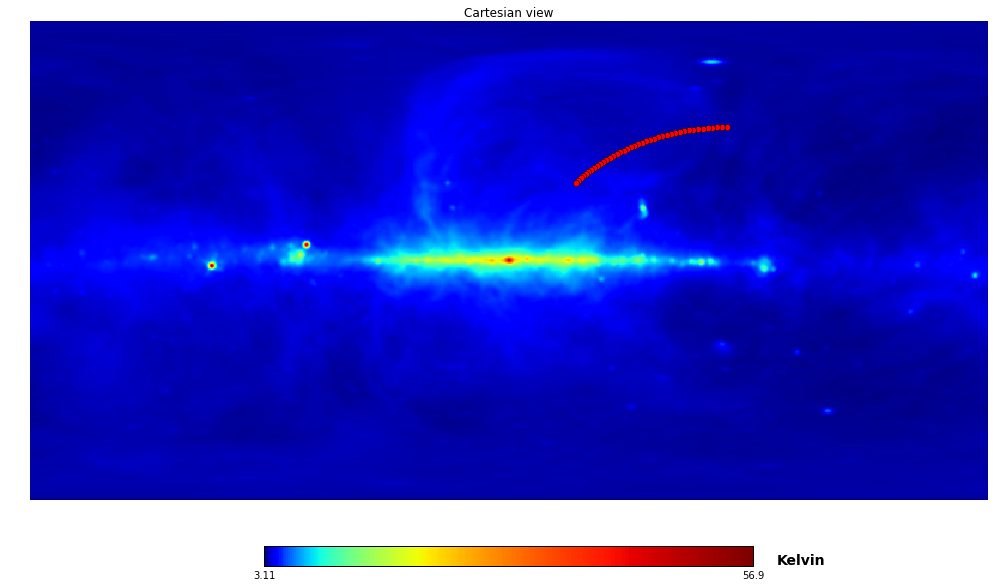

In [17]:
fig = T_SysTemp.sky_fig()
fig.savefig(pp,format='pdf')

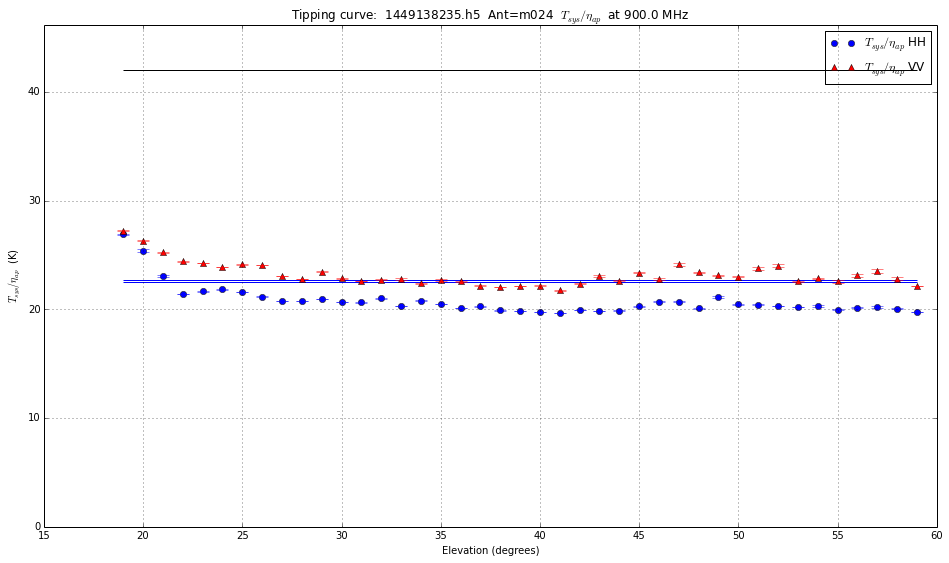

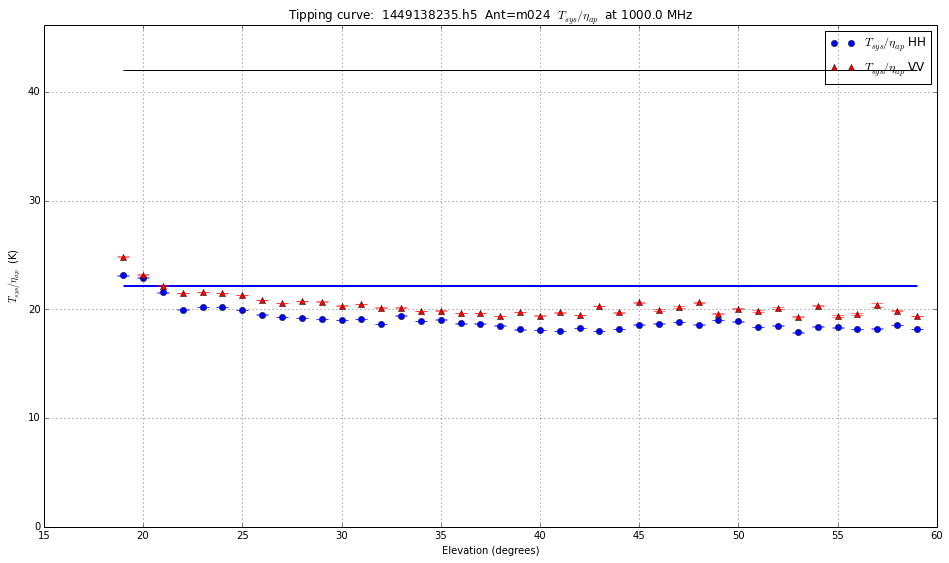

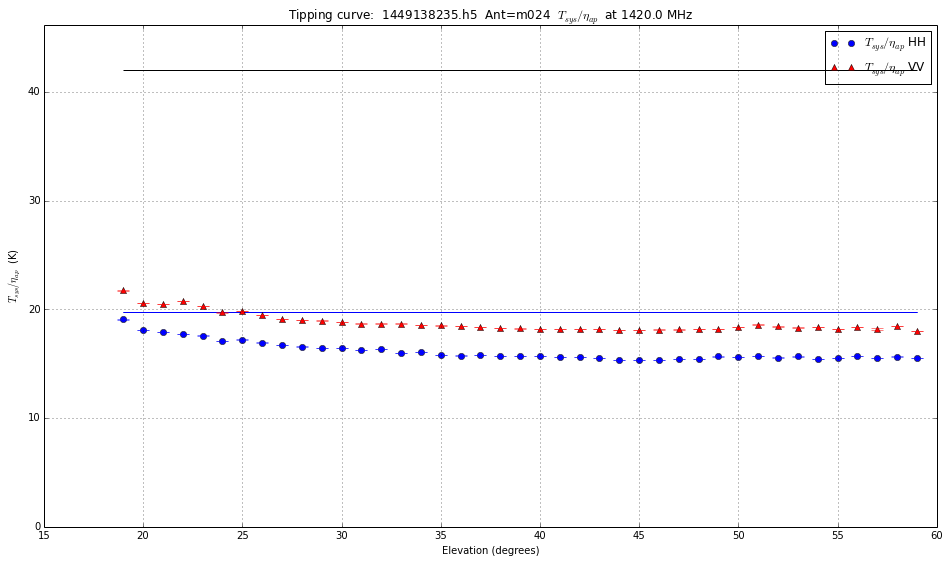

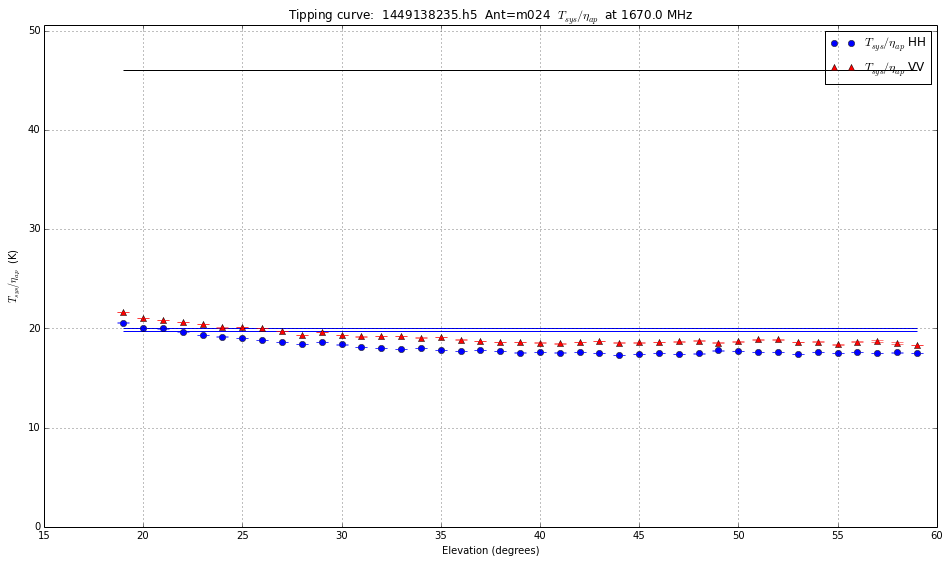

In [18]:
for freq in select_freq :
    title = ""
    if np.abs(freq_list-freq).min() < freq_bw*1.1 :
        i = (np.abs(freq_list-freq)).argmin()
        lineval = 42
        if freq > 1420 : lineval = 46
        fig = plot_data_el(tsys[0:length,i,:],tant[0:length,i,:],title=r"%s  $T_{sys}/\eta_{ap}$  at %.1f MHz"%(nice_title,freq),units=units,line=lineval,aperture_efficiency=aperture_efficiency,frequency=d.freqs[i])
        fig.savefig(pp,format='pdf')


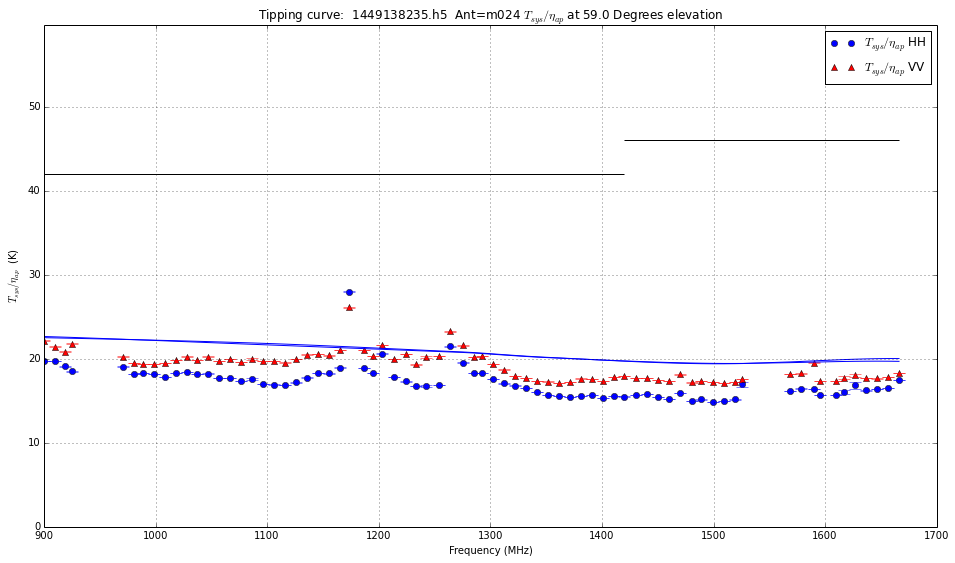

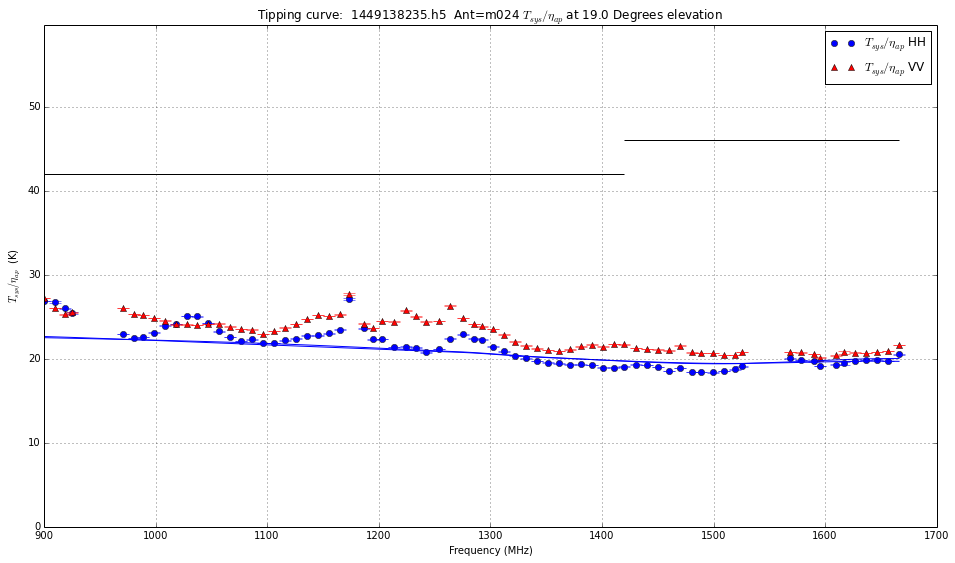

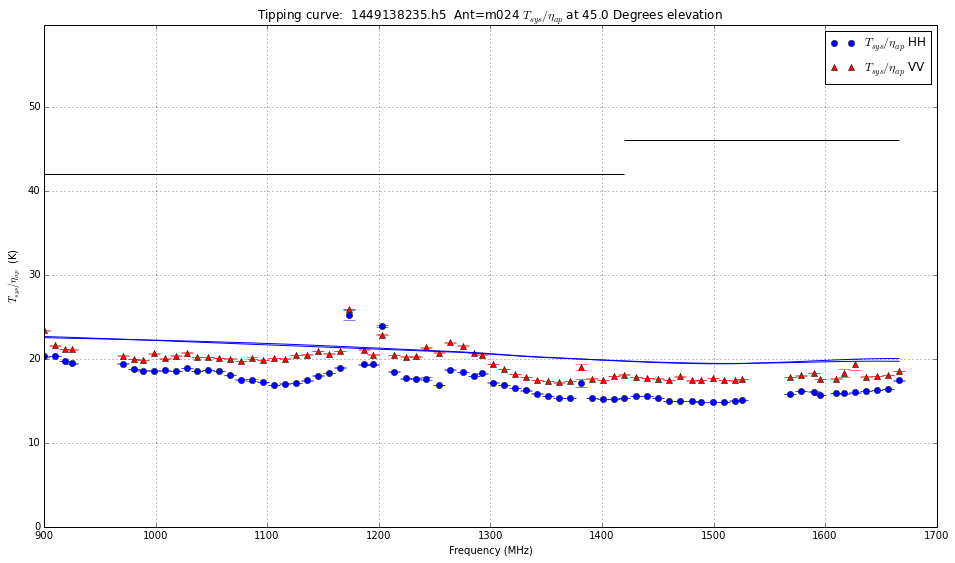

In [19]:
for el in select_el :
    title = ""
    i = (np.abs(tsys[0:length,:,2].max(axis=1)-el)).argmin()
    fig = plot_data_freq(freq_list[4:-5],tsys[i,4:-5,:],tant[i,4:-5,:],title=r"%s $T_{sys}/\eta_{ap}$ at %.1f Degrees elevation"%(nice_title,np.abs(tsys[0:length,:,2].max(axis=1))[i]),aperture_efficiency=aperture_efficiency)
    fig.savefig(pp,format='pdf')


In [20]:
pp.close()
freq_list.shape

(82,)